# Experimental XGBoost model

using KPIs previously discussed and preprocessed player data from the ffn notebook

### Imports

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### load train data

In [3]:
# only consider CC heroes
# CC_ONLY: bool = False

# aggregate to rank groups 10, 20, ... instead of 11, ..., 15, 21, ..., 25 for simplification ?
AGGREGATE_RANKS: bool = True

In [ ]:
df = pd.read_csv(os.path.join("..", "..", "resources", "data", "player_data.csv.bz2"), index_col=0)
print(df.head())

if AGGREGATE_RANKS:
    # simplification
    df["rank_tier"] = (df["rank_tier"] // 10).astype("category")
else:
    # target var should be categorical
    df["rank_tier"] = df["rank_tier"].astype("category")

### split and stratify

In [5]:
# 2. Separate features and target
X = df.iloc[:, 2:]       # columns 2..end
y = df.iloc[:, 0]        # first column

# 3. Encode target if it's string
if y.dtype == object or y.dtype.name == 'category':
    le = LabelEncoder()
    y = le.fit_transform(y)

# 4. Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### xgboost model

In [38]:
# 5. Instantiate XGBoost classifier
model = XGBClassifier(
    objective='multi:softprob',  # or 'binary:logistic' for two classes
    num_class=len(set(y)),       # only for multi-class
    eval_metric='mlogloss',      # change to 'error' or 'auc' as needed
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

In [39]:
# 6. Train with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# 7. Evaluate
y_pred = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}\n")
print(classification_report(y_val, y_pred))

[0]	validation_0-mlogloss:1.92171
[1]	validation_0-mlogloss:1.90011
[2]	validation_0-mlogloss:1.88081
[3]	validation_0-mlogloss:1.86293
[4]	validation_0-mlogloss:1.84706
[5]	validation_0-mlogloss:1.83257
[6]	validation_0-mlogloss:1.81923
[7]	validation_0-mlogloss:1.80726
[8]	validation_0-mlogloss:1.79621
[9]	validation_0-mlogloss:1.78587
[10]	validation_0-mlogloss:1.77652
[11]	validation_0-mlogloss:1.76805
[12]	validation_0-mlogloss:1.75995
[13]	validation_0-mlogloss:1.75254
[14]	validation_0-mlogloss:1.74562
[15]	validation_0-mlogloss:1.73919
[16]	validation_0-mlogloss:1.73330
[17]	validation_0-mlogloss:1.72791
[18]	validation_0-mlogloss:1.72287
[19]	validation_0-mlogloss:1.71833
[20]	validation_0-mlogloss:1.71385
[21]	validation_0-mlogloss:1.70994
[22]	validation_0-mlogloss:1.70600
[23]	validation_0-mlogloss:1.70253
[24]	validation_0-mlogloss:1.69926
[25]	validation_0-mlogloss:1.69635
[26]	validation_0-mlogloss:1.69333
[27]	validation_0-mlogloss:1.69064
[28]	validation_0-mlogloss:1.6

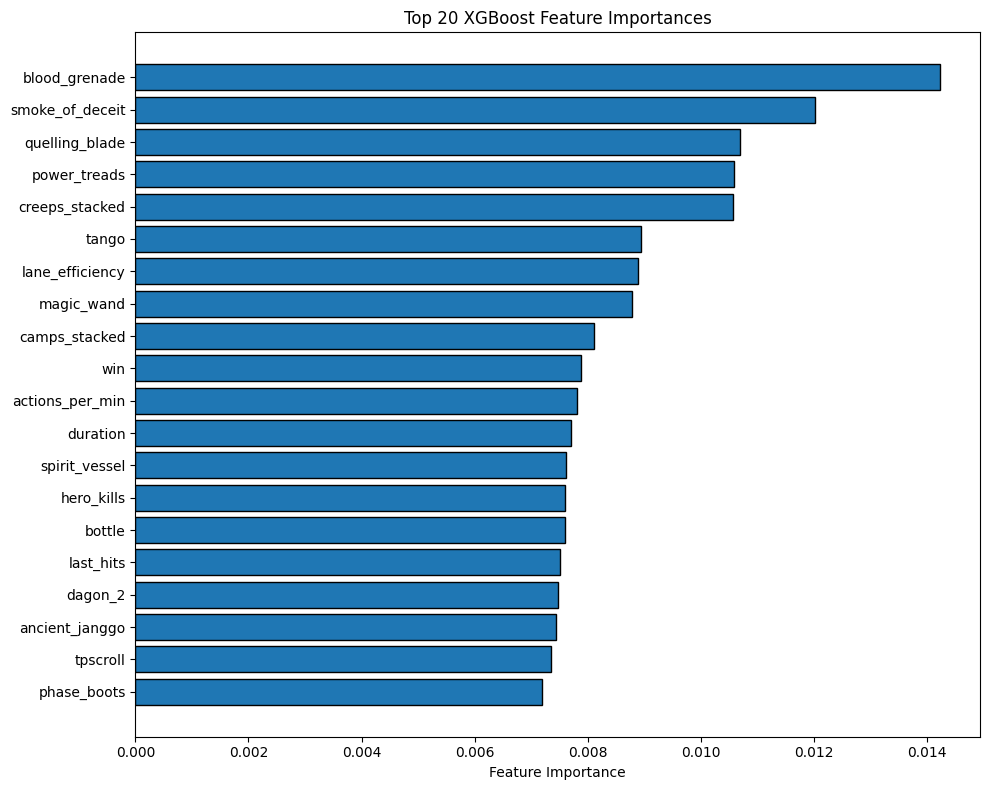

In [43]:
# 1) Grab importances (length = number of features the model saw)
importances = model.feature_importances_

# 2) Grab the exact feature names the model recorded
feature_names = model.get_booster().feature_names  # or model.feature_names_in_

# 3) Sort descending and take the top 20
top_idx = np.argsort(importances)[::-1][:20]
top_features    = [feature_names[i] for i in top_idx]
top_importances = importances[top_idx]

# 4) Plot
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_importances, edgecolor='k')
plt.gca().invert_yaxis()  # so the largest is at the top
plt.xlabel("Feature Importance")
plt.title("Top 20 XGBoost Feature Importances")
plt.tight_layout()
plt.show()

### Hyperparameter tuning WIP

In [44]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

In [ ]:
# Create the XGBoost model object
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(set(y)), 
    eval_metric='mlogloss')

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)